In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Upload the datasets
uploaded = files.upload()

# Load the datasets
electricity_prices_df = pd.read_csv('processed_simulated_paths_no_year.csv')
capacity_factors_df = pd.read_csv('Capacity_Data_by_Hour_and_Year.csv')

Saving Capacity_Data_by_Hour_and_Year.csv to Capacity_Data_by_Hour_and_Year.csv
Saving processed_simulated_paths_no_year.csv to processed_simulated_paths_no_year.csv


In [ ]:
print("Capacity Factors DataFrame columns:")
print(capacity_factors_df.columns)

print("\nElectricity Prices DataFrame columns:")
print(electricity_prices_df.columns)


Capacity Factors DataFrame columns:
Index(['Hour', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990',
       '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')

Electricity Prices DataFrame columns:
Index(['Date', 'Path_1', 'Path_10', 'Path_11', 'Path_12', 'Path_13', 'Path_14',
       'Path_15', 'Path_16', 'Path_17', 'Path_18', 'Path_19', 'Path_2',
       'Path_20', 'Path_3', 'Path_4', 'Path_5', 'Path_6', 'Path_7', 'Path_8',
       'Path_9'],
      dtype='object')


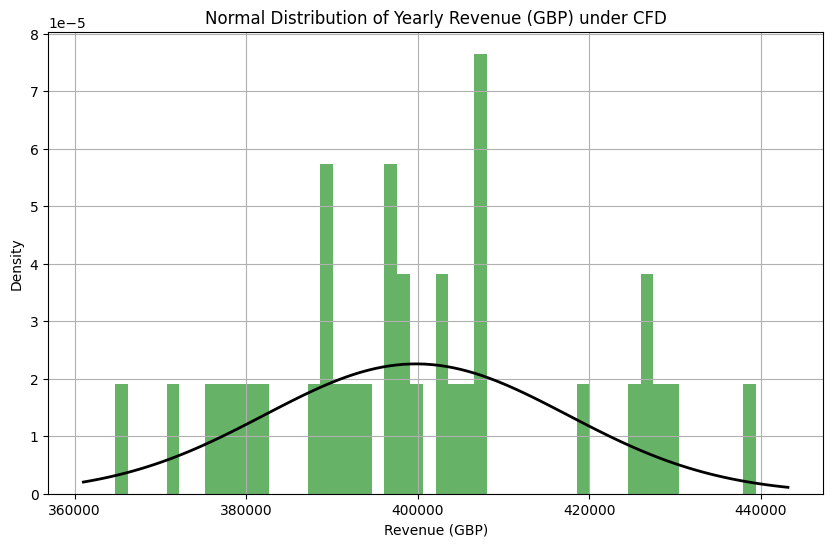

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define a function to calculate yearly revenue for all combinations of paths and capacity factors under CFD
def calculate_revenue_all_combinations(capacity_factors_df, strike_price):
    revenues = []
    for year in capacity_factors_df.columns[1:]:
        # Select the specific year
        capacity_factors = capacity_factors_df[year]

        # Calculate the revenue for this combination under CFD
        revenue = np.sum(strike_price * capacity_factors)
        revenues.append(revenue)

    return revenues

# Define the strike price for CFD
strike_price = 76
# Calculate revenues for all combinations
revenues = calculate_revenue_all_combinations(capacity_factors_df, strike_price)

# Plot the normal distribution of the revenues
plt.figure(figsize=(10, 6))
plt.hist(revenues, bins=50, density=True, alpha=0.6, color='g')

# Add the normal distribution curve
mean = np.mean(revenues)
std_dev = np.std(revenues)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5 * ((x - mean) / std_dev) ** 2) / (std_dev * np.sqrt(2 * np.pi))
plt.plot(x, p, 'k', linewidth=2)

plt.title('Normal Distribution of Yearly Revenue (GBP) under CFD')
plt.xlabel('Revenue (GBP)')
plt.ylabel('Density')
plt.grid(True)
plt.show()


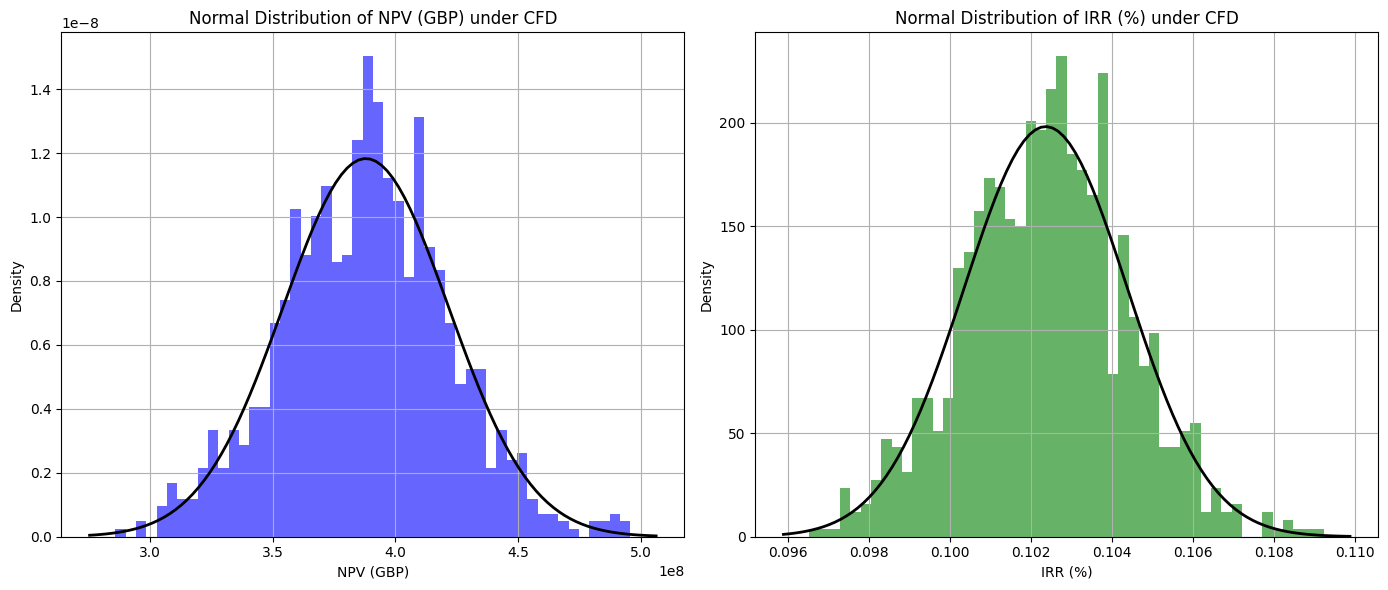

mean_npv: 387969265.7264596 GBP
std_dev_npv: 33721856.121584974 GBP
mean_irr: 10.235892186481141 %
std_dev_irr: 0.20127466153171925 %


In [ ]:
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt

# 已知参数
installed_capacity_mw = 800  # 800 MW
project_lifetime_years = 25  # 项目年限25年
capex_per_kw = 2500  # £2,500 每千瓦 (kW)
opex_per_mw_per_year = 100000  # 每年运营支出
discount_rate = 0.08  # 折现率 8%
annual_degradation = 0.005  # 每年0.5%的效率降低

# 定义电网接入成本
grid_connection_cost_per_km = 750000  # 电网接入成本每公里£750,000
grid_connection_distance_km = 50  # 默认距离50公里

# 计算总CAPEX和每年的OPEX
total_capex = installed_capacity_mw * 1000 * capex_per_kw  # 总资本支出
annual_opex = installed_capacity_mw * opex_per_mw_per_year  # 每年运营支出

# 添加一次性电网接入成本
grid_connection_cost = grid_connection_cost_per_km * grid_connection_distance_km
total_capex += grid_connection_cost  # 将其包含在总CAPEX中

# Generate yearly revenues (using the already calculated 'revenues' list)
def generate_yearly_revenues(revenues, project_lifetime_years, annual_degradation):
    selected_revenues = []
    for year in range(project_lifetime_years):
        revenue = np.random.choice(revenues) * (1 - annual_degradation) ** year
        selected_revenues.append(revenue)
    return selected_revenues

# 计算NPV和IRR
def calculate_npv_irr_corrected(revenues, total_capex, annual_opex, discount_rate, installed_capacity_mw):
    # Generate yearly revenues
    yearly_revenues = generate_yearly_revenues(revenues, project_lifetime_years, annual_degradation)
    # Adjust revenues by installed capacity
    adjusted_yearly_revenues = [revenue * installed_capacity_mw for revenue in yearly_revenues]

    # Calculate yearly cash flows (Revenue - OPEX)
    yearly_cash_flows = [(revenue - annual_opex) for revenue in adjusted_yearly_revenues]

    # Add initial CAPEX as the first cash flow (negative)
    cash_flows = [-total_capex] + yearly_cash_flows

    # Calculate NPV
    npv_value = npf.npv(discount_rate, cash_flows)

    # Calculate IRR
    irr_value = npf.irr(cash_flows)

    return npv_value, irr_value

# 执行多次模拟
def simulate_npv_irr(revenues, total_capex, annual_opex, discount_rate, installed_capacity_mw, num_simulations=1000):
    npv_values = []
    irr_values = []
    for _ in range(num_simulations):
        npv, irr = calculate_npv_irr_corrected(revenues, total_capex, annual_opex, discount_rate, installed_capacity_mw)
        npv_values.append(npv)
        irr_values.append(irr)
    return npv_values, irr_values

# 运行模拟
num_simulations = 1000  # 可以设置为2000
npv_values, irr_values = simulate_npv_irr(revenues, total_capex, annual_opex, discount_rate, installed_capacity_mw, num_simulations)

# 计算统计数据
mean_npv = np.mean(npv_values)
std_dev_npv = np.std(npv_values)
mean_irr = np.mean(irr_values)
std_dev_irr = np.std(irr_values)

# 绘制NPV和IRR的正态分布图
plt.figure(figsize=(14, 6))

# NPV分布
plt.subplot(1, 2, 1)
plt.hist(npv_values, bins=50, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5 * ((x - mean_npv) / std_dev_npv) ** 2) / (std_dev_npv * np.sqrt(2 * np.pi))
plt.plot(x, p, 'k', linewidth=2)
plt.title('Normal Distribution of NPV (GBP) under CFD')
plt.xlabel('NPV (GBP)')
plt.ylabel('Density')
plt.grid(True)

# IRR分布
plt.subplot(1, 2, 2)
plt.hist(irr_values, bins=50, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5 * ((x - mean_irr) / std_dev_irr) ** 2) / (std_dev_irr * np.sqrt(2 * np.pi))
plt.plot(x, p, 'k', linewidth=2)
plt.title('Normal Distribution of IRR (%) under CFD')
plt.xlabel('IRR (%)')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout()
plt.show()

# 输出统计数据
print("mean_npv:", mean_npv, "GBP")
print("std_dev_npv:", std_dev_npv, "GBP")
print("mean_irr:", mean_irr * 100, "%")
print("std_dev_irr:", std_dev_irr * 100, "%")


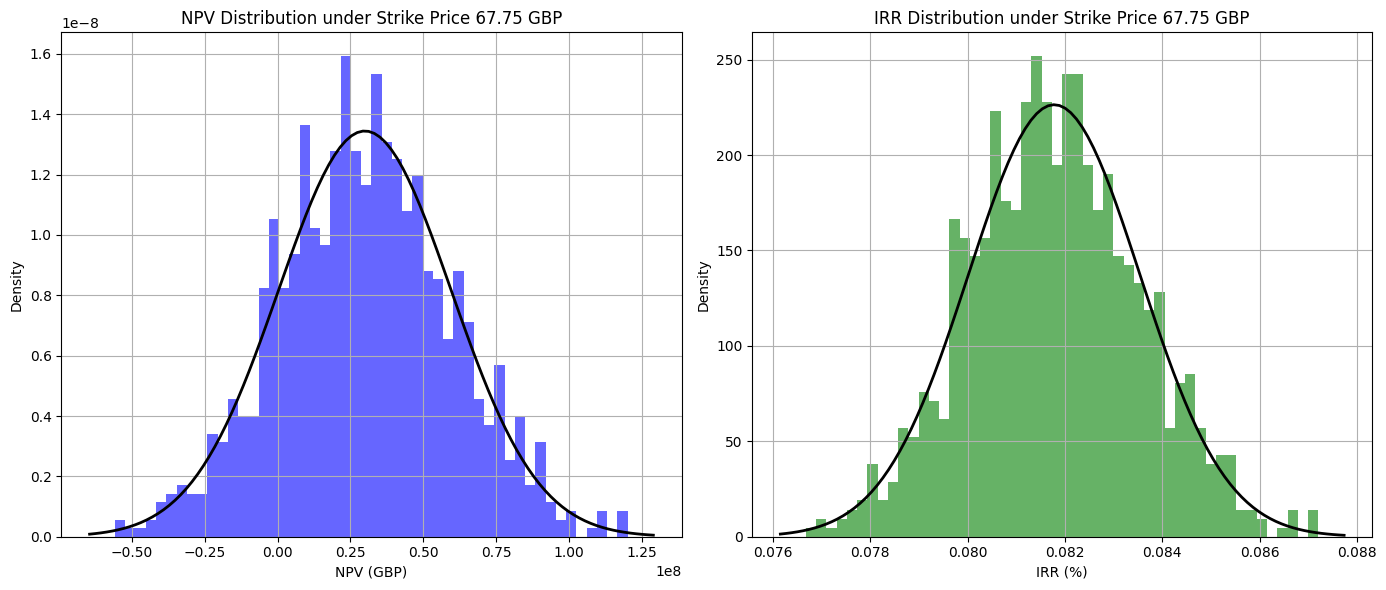

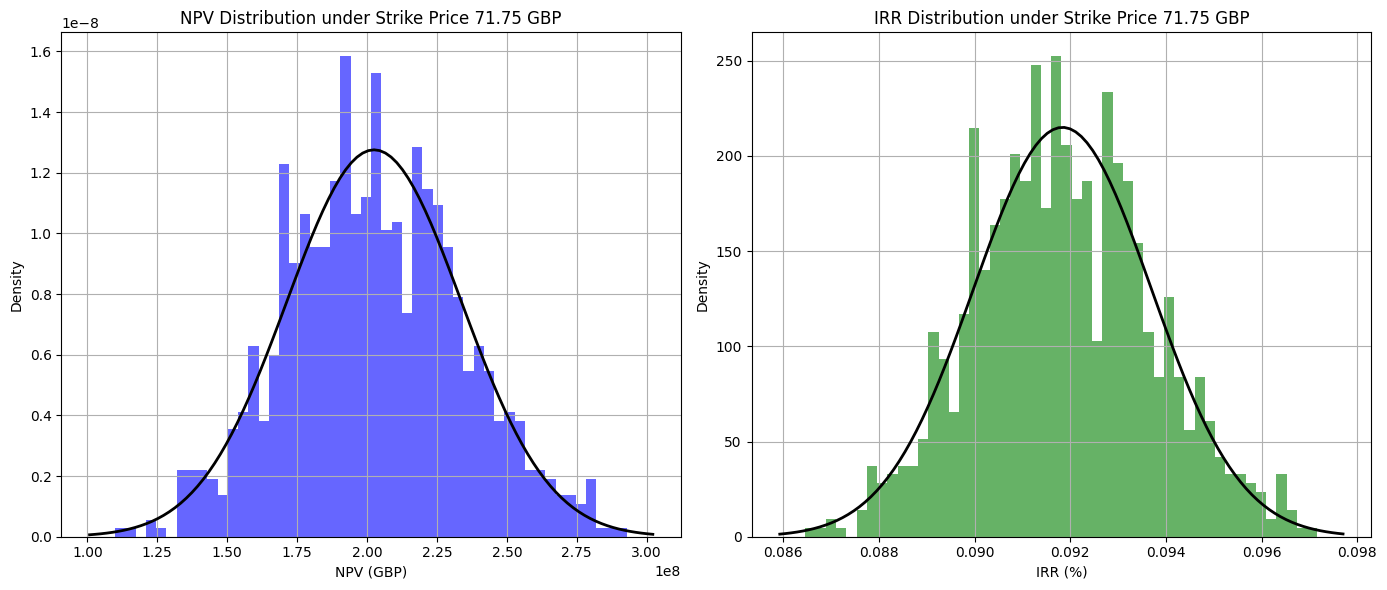

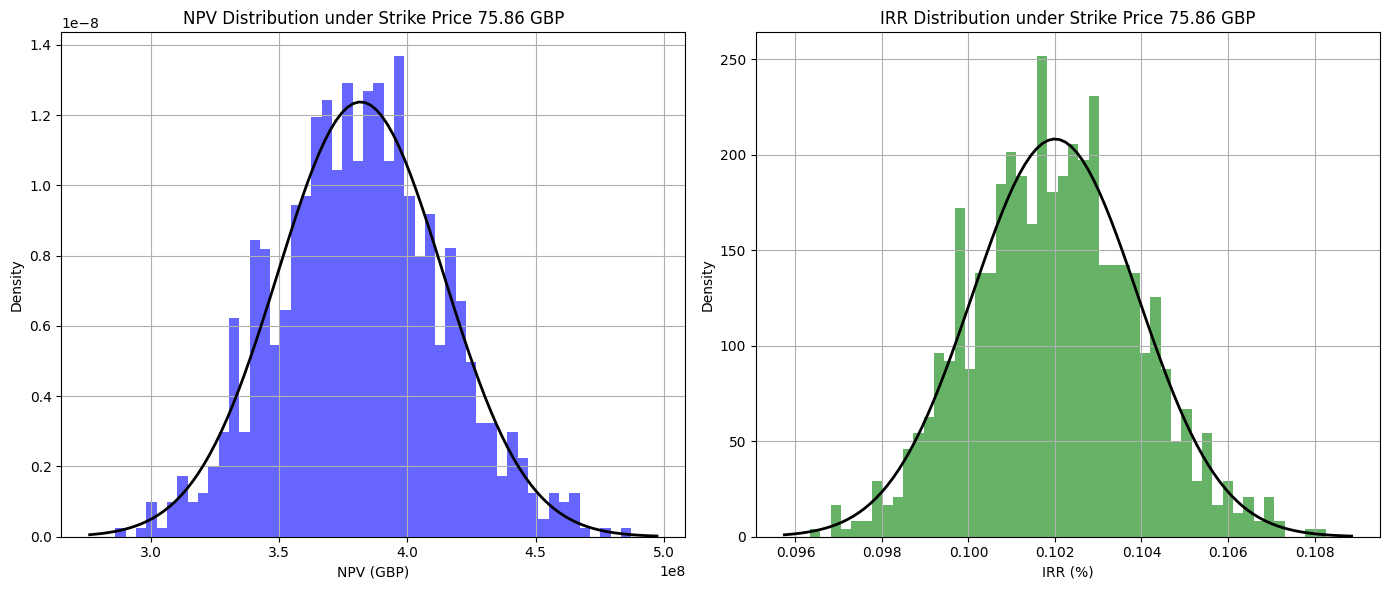

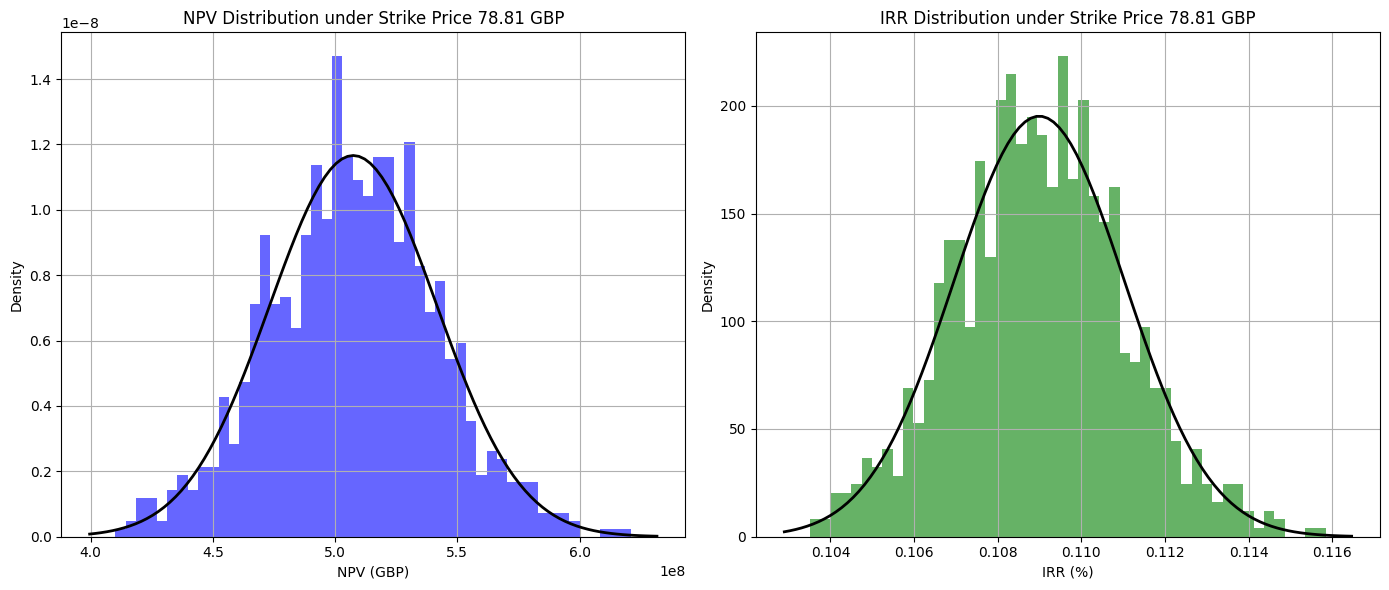

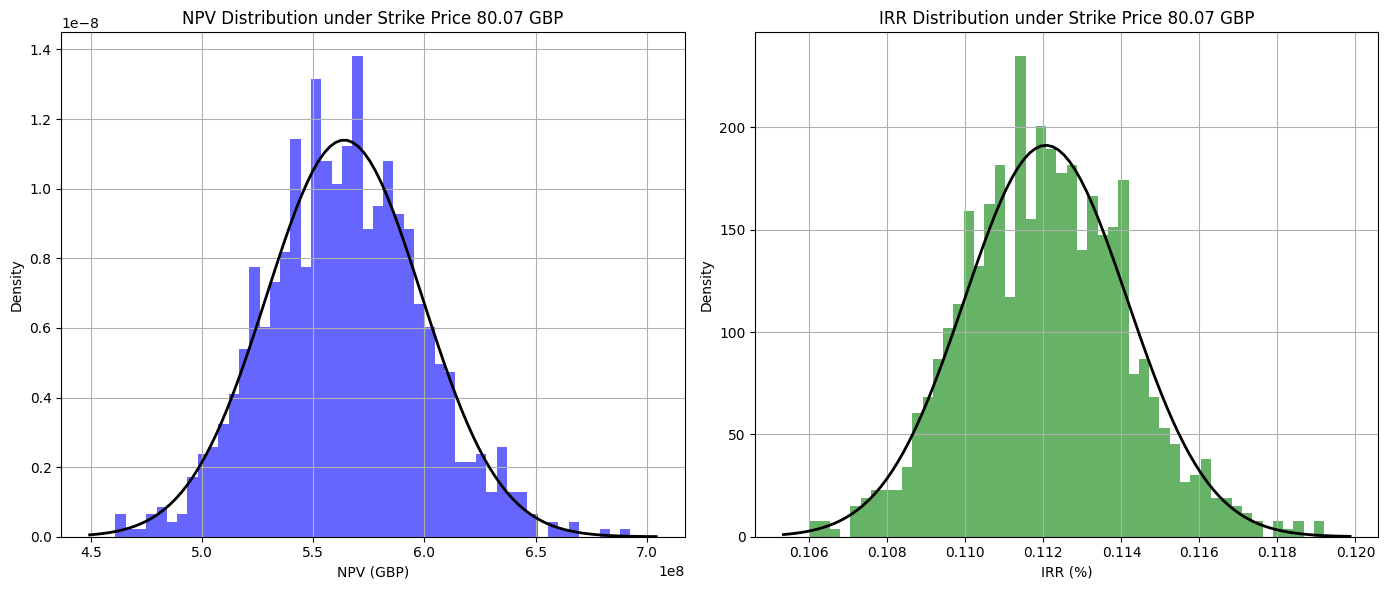

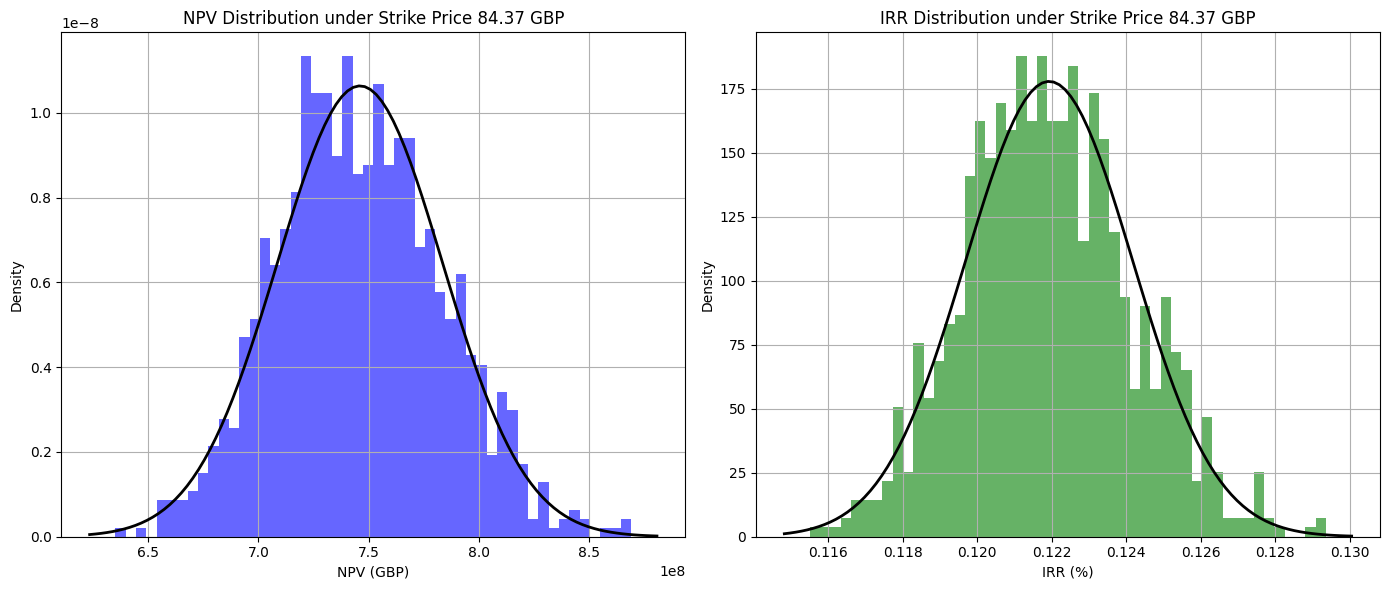

In [ ]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt



# 定义计算每个组合在CFD下的年度收入的函数
def calculate_revenue_all_combinations(capacity_factors_df, strike_price):
    revenues = []
    for year in capacity_factors_df.columns[1:]:
        # 选择特定年份的容量因子
        capacity_factors = capacity_factors_df[year]

        # 计算在该年份下的收入
        revenue = np.sum(strike_price * capacity_factors)
        revenues.append(revenue)

    return revenues

# 定义项目参数
installed_capacity_mw = 800  # 800 MW
project_lifetime_years = 25  # 项目年限25年
capex_per_kw = 2500  # £2,500 每千瓦 (kW)
opex_per_mw_per_year = 100000  # 每年运营支出
discount_rate = 0.08  # 折现率 8%
annual_degradation = 0.005  # 每年0.5%的效率降低

# 电网接入成本
grid_connection_cost_per_km = 750000  # 电网接入成本每公里£750,000
grid_connection_distance_km = 50  # 默认距离50公里

# 计算总CAPEX和每年的OPEX
total_capex = installed_capacity_mw * 1000 * capex_per_kw  # 总资本支出
annual_opex = installed_capacity_mw * opex_per_mw_per_year  # 每年运营支出

# 添加一次性电网接入成本
grid_connection_cost = grid_connection_cost_per_km * grid_connection_distance_km
total_capex += grid_connection_cost  # 将其包含在总CAPEX中

# 生成每年的收入
def generate_yearly_revenues(revenues, project_lifetime_years, annual_degradation):
    selected_revenues = []
    for year in range(project_lifetime_years):
        revenue = np.random.choice(revenues) * (1 - annual_degradation) ** year
        selected_revenues.append(revenue)
    return selected_revenues

# 计算NPV和IRR
def calculate_npv_irr_corrected(revenues, total_capex, annual_opex, discount_rate, installed_capacity_mw):
    yearly_revenues = generate_yearly_revenues(revenues, project_lifetime_years, annual_degradation)
    adjusted_yearly_revenues = [revenue * installed_capacity_mw for revenue in yearly_revenues]

    yearly_cash_flows = [(revenue - annual_opex) for revenue in adjusted_yearly_revenues]
    cash_flows = [-total_capex] + yearly_cash_flows

    npv_value = npf.npv(discount_rate, cash_flows)
    irr_value = npf.irr(cash_flows)

    return npv_value, irr_value

# 运行模拟
def simulate_npv_irr(revenues, total_capex, annual_opex, discount_rate, installed_capacity_mw, num_simulations=1000):
    npv_values = []
    irr_values = []
    for _ in range(num_simulations):
        npv, irr = calculate_npv_irr_corrected(revenues, total_capex, annual_opex, discount_rate, installed_capacity_mw)
        npv_values.append(npv)
        irr_values.append(irr)
    return npv_values, irr_values

# 定义不同的strike price
strike_prices = [67.75, 71.75, 75.86, 78.81, 80.07, 84.37]

# 对每个strike price计算NPV和IRR分布并绘图
for strike_price in strike_prices:
    # 计算对应的revenue
    revenues = calculate_revenue_all_combinations(capacity_factors_df, strike_price)

    # 进行模拟
    npv_values, irr_values = simulate_npv_irr(revenues, total_capex, annual_opex, discount_rate, installed_capacity_mw, num_simulations=1000)

    # 绘制NPV的直方图和正态分布曲线
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.hist(npv_values, bins=50, density=True, alpha=0.6, color='b')
    mean_npv = np.mean(npv_values)
    std_dev_npv = np.std(npv_values)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = np.exp(-0.5 * ((x - mean_npv) / std_dev_npv) ** 2) / (std_dev_npv * np.sqrt(2 * np.pi))
    plt.plot(x, p, 'k', linewidth=2)
    plt.title(f'NPV Distribution under Strike Price {strike_price} GBP')
    plt.xlabel('NPV (GBP)')
    plt.ylabel('Density')
    plt.grid(True)

    # 绘制IRR的直方图和正态分布曲线
    plt.subplot(1, 2, 2)
    plt.hist(irr_values, bins=50, density=True, alpha=0.6, color='g')
    mean_irr = np.mean(irr_values)
    std_dev_irr = np.std(irr_values)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = np.exp(-0.5 * ((x - mean_irr) / std_dev_irr) ** 2) / (std_dev_irr * np.sqrt(2 * np.pi))
    plt.plot(x, p, 'k', linewidth=2)
    plt.title(f'IRR Distribution under Strike Price {strike_price} GBP')
    plt.xlabel('IRR (%)')
    plt.ylabel('Density')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


   Strike Price (GBP)  Mean NPV (GBP)  Std Dev NPV (GBP)  Skewness NPV  \
0               67.75    3.046700e+07       2.878185e+07     -0.011569   
1               71.75    2.037066e+08       3.169051e+07      0.087694   
2               75.86    3.801730e+08       3.284349e+07      0.168588   
3               78.81    5.104260e+08       3.538249e+07      0.092730   
4               80.07    5.613442e+08       3.434902e+07      0.120870   
5               84.37    7.448672e+08       3.752966e+07      0.175916   

   Kurtosis NPV  Mean IRR (%)  Std Dev IRR (%)  Skewness IRR  Kurtosis IRR  
0     -0.233216      8.180849         0.170942     -0.001659     -0.232123  
1     -0.098310      9.190721         0.188672      0.110088     -0.087090  
2     -0.126569     10.190501         0.195393      0.194534     -0.119955  
3     -0.318818     10.915654         0.210795      0.113590     -0.333089  
4     -0.101889     11.194206         0.205884      0.143889     -0.098297  
5     -0.211185    

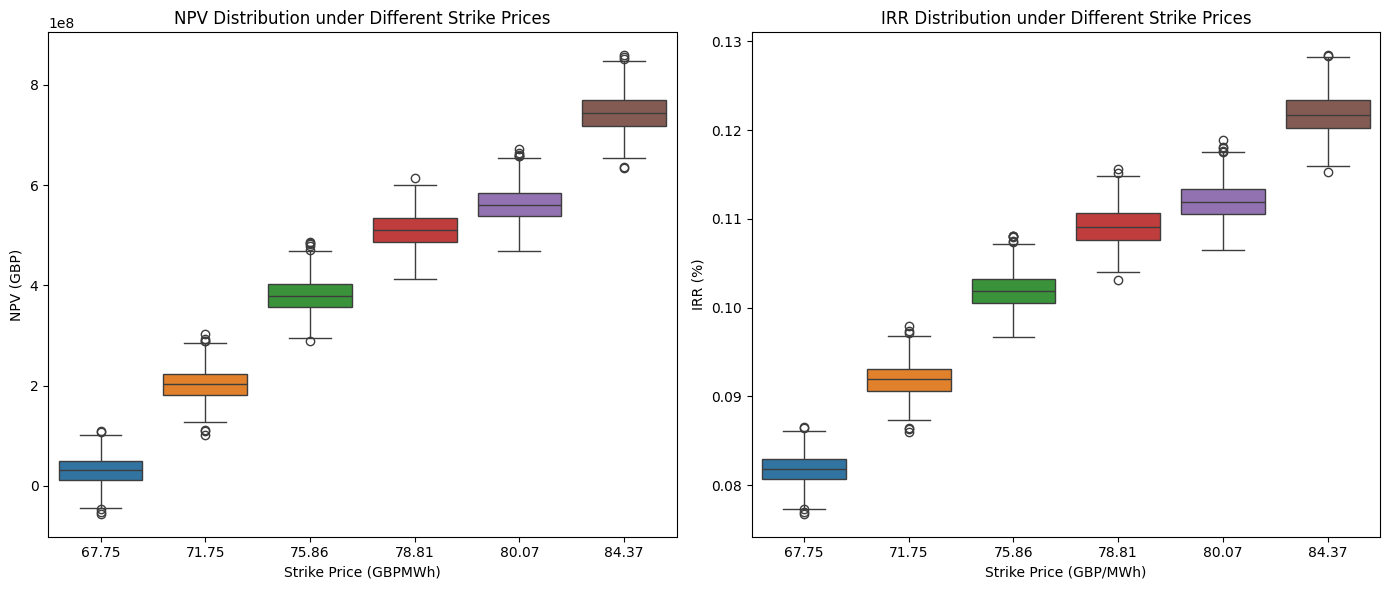

In [ ]:
from scipy.stats import skew, kurtosis
import seaborn as sns

# 存储每个strike price下的统计数据
statistics_summary = []

# 存储用于绘制箱线图的数据
npv_distributions = []
irr_distributions = []

# 对每个strike price计算NPV和IRR分布并绘图
for strike_price in strike_prices:
    # 计算对应的revenue
    revenues = calculate_revenue_all_combinations(capacity_factors_df, strike_price)

    # 进行模拟
    npv_values, irr_values = simulate_npv_irr(revenues, total_capex, annual_opex, discount_rate, installed_capacity_mw, num_simulations=1000)

    # 计算统计数据
    mean_npv = np.mean(npv_values)
    std_dev_npv = np.std(npv_values)
    skew_npv = skew(npv_values)
    kurt_npv = kurtosis(npv_values)

    mean_irr = np.mean(irr_values)
    std_dev_irr = np.std(irr_values)
    skew_irr = skew(irr_values)
    kurt_irr = kurtosis(irr_values)

    # 将统计数据存储到列表中
    statistics_summary.append({
        "Strike Price (GBP)": strike_price,
        "Mean NPV (GBP)": mean_npv,
        "Std Dev NPV (GBP)": std_dev_npv,
        "Skewness NPV": skew_npv,
        "Kurtosis NPV": kurt_npv,
        "Mean IRR (%)": mean_irr * 100,
        "Std Dev IRR (%)": std_dev_irr * 100,
        "Skewness IRR": skew_irr,
        "Kurtosis IRR": kurt_irr
    })

    # 存储分布数据用于绘制箱线图
    npv_distributions.append(npv_values)
    irr_distributions.append(irr_values)

# 输出统计数据
statistics_df = pd.DataFrame(statistics_summary)
print(statistics_df)

# 绘制箱线图
plt.figure(figsize=(14, 6))

# NPV的箱线图
plt.subplot(1, 2, 1)
sns.boxplot(data=npv_distributions)
plt.xticks(ticks=range(len(strike_prices)), labels=strike_prices)
plt.title('NPV Distribution under Different Strike Prices')
plt.xlabel('Strike Price (GBPMWh)')
plt.ylabel('NPV (GBP)')

# IRR的箱线图
plt.subplot(1, 2, 2)
sns.boxplot(data=irr_distributions)
plt.xticks(ticks=range(len(strike_prices)), labels=strike_prices)
plt.title('IRR Distribution under Different Strike Prices')
plt.xlabel('Strike Price (GBP/MWh)')
plt.ylabel('IRR (%)')

plt.tight_layout()
plt.show()


In [ ]:
# 定义置信水平
confidence_level = 0.05  # 95%置信水平对应的VaR

# 存储每个strike price下的VaR和CVaR
risk_measures = []

for i, strike_price in enumerate(strike_prices):
    # 获取当前的NPV和IRR分布
    npv_values = npv_distributions[i]
    irr_values = irr_distributions[i]

    # 计算NPV的VaR和CVaR
    npv_var = np.percentile(npv_values, confidence_level * 100)
    npv_cvar = np.mean([x for x in npv_values if x <= npv_var])

    # 计算IRR的VaR和CVaR
    irr_var = np.percentile(irr_values, confidence_level * 100)
    irr_cvar = np.mean([x for x in irr_values if x <= irr_var])

    # 存储结果
    risk_measures.append({
        "Strike Price (GBP)": strike_price,
        "VaR NPV (GBP)": npv_var,
        "CVaR NPV (GBP)": npv_cvar,
        "VaR IRR (%)": irr_var * 100,
        "CVaR IRR (%)": irr_cvar * 100
    })

# 输出VaR和CVaR数据
risk_df = pd.DataFrame(risk_measures)
print(risk_df)


   Strike Price (GBP)  VaR NPV (GBP)  CVaR NPV (GBP)  VaR IRR (%)  \
0               67.75  -1.624730e+07   -2.834604e+07     7.904174   
1               71.75   1.529266e+08    1.412090e+08     8.886048   
2               75.86   3.284459e+08    3.165592e+08     9.885826   
3               78.81   4.543541e+08    4.411903e+08    10.582389   
4               80.07   5.066158e+08    4.931957e+08    10.860825   
5               84.37   6.856518e+08    6.744884e+08    11.840158   

   CVaR IRR (%)  
0      7.832326  
1      8.820496  
2      9.814863  
3     10.507898  
4     10.787569  
5     11.773817  
